In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [20]:
df= pd.read_csv("AI_data.csv")

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   From            120 non-null    object 
 1   To              120 non-null    object 
 2   Algorithm       120 non-null    object 
 3   Distance        120 non-null    float64
 4   Nodes Expanded  120 non-null    int64  
 5   Execution Time  120 non-null    float64
 6   Path Length     120 non-null    int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 6.7+ KB


In [22]:
df.head()

,From,To,Algorithm,Distance,Nodes Expanded,Execution Time,Path Length
0,"Potsdam, NY","Detroit, IL",UCS (Dijkstra),1010.4,681,8.76,10
1,"Potsdam, NY","Detroit, IL",A* (Haversine),1010.4,453,7.45,10
2,"Potsdam, NY","Detroit, IL",A* (Euclidean),1026.5,110,1.92,10
3,"Potsdam, NY","Detroit, IL",A* (Manhattan),1045.5,140,2.30,10
4,"Potsdam, NY","Detroit, IL",A* (Min Graph),1010.4,675,8.29,10


In [23]:
def categorize_distance(distance):
        if distance>0 and distance < 500:
            return "Short (<500 mi)"
        elif distance>500 and distance < 1200:
            return "Medium (500-1200 mi)"
        else:
            return "Long from 1600mi"

In [24]:
# Set visual style for the presentation
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 150 # High resolution for PPT

In [25]:
# --- Data Standardization Function (Standardize ALL names for consistent grouping) ---
def standardize_algorithm_names(df):
    """Standardizes different algorithm variations to a single name for plotting."""
    df_copy = df.copy()
    
    # 1. Standardize A* names (Group all A* heuristics together for cross-algorithm comparisons)
    a_star_names = df_copy[df_copy['Algorithm'].str.contains('A\*', regex=True)]['Algorithm'].unique()
    df_copy['Algorithm'] = df_copy['Algorithm'].replace(a_star_names, 'A* Search (All)')
    
    # 2. Standardize Uninformed Search names
    df_copy['Algorithm'] = df_copy['Algorithm'].replace('UCS (Dijkstra)', 'UCS')
    df_copy['Algorithm'] = df_copy['Algorithm'].replace('Greedy Best-First', 'Greedy')
    df_copy['Algorithm'] = df_copy['Algorithm'].replace('Depth-First Search', 'DFS')
    
    return df_copy

In [26]:
df = standardize_algorithm_names(df)

df['Distance Category'] = df['Distance'].apply(categorize_distance)

df['Route'] = df['From'] + ' to ' + df['To']
df_min_dist = df.groupby('Route')['Distance'].min().reset_index()
df_min_dist.rename(columns={'Distance': 'Optimal Distance'}, inplace=True)
df = pd.merge(df, df_min_dist, on='Route', how='left')

In [27]:
# CHART1- how A* advantange widens with distance:
def plot_efficiency_scaling(df):
    """
    Generates a Line Chart comparing average Nodes Expanded across distance categories 
    for all algorithms, showing how A* efficiency scales.
    """
    
    # Define a clear order for the distance categories
    distance_order = ["Short (<500 mi)", "Medium (500-1200 mi)", "Long from 1600mi"]
    
    # Aggregate data by Category and Algorithm
    df_agg = df.groupby(['Distance Category', 'Algorithm'])['Nodes Expanded'].mean().reset_index()
    
    plt.figure(figsize=(10, 6))
    
    sns.lineplot(
        data=df_agg, 
        x='Distance Category', 
        y='Nodes Expanded', 
        hue='Algorithm', 
        marker='o',
        dashes=False, # Use solid lines
        linewidth=2.5,
        # Ensure categories are in order
        hue_order=['UCS', 'A* Search (All)', 'Greedy', 'DFS'] 
    )
    
    plt.title('Chart 1: Algorithm Efficiency Scaling (Nodes vs. Distance)', fontsize=14)
    plt.xlabel('Route Distance Complexity', fontsize=12)
    plt.ylabel('Average Nodes Expanded', fontsize=12)
    plt.xticks(rotation=0)
    plt.legend(title='Algorithm')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Observation point for PPT: Highlight the widening gap between UCS and A*
    plt.tight_layout()
    plt.show()
    plt.savefig('chart1_efficiency_scaling.png')
    plt.close()

In [ ]:
# CHART2- optimality gap
# This shows the cost penalty paid by Greedy/DFS compared to the optimal $\text{A}^*$/UCS path

def plot_optimality_gap_average(df):
    """
    Generates a Grouped Bar Chart showing the average distance penalty 
    (Optimality Gap) for sub-optimal algorithms.
    """
    
    # Calculate the percentage increase from the optimal path for each row
    df['Distance Penalty (%)'] = ((df['Distance'] - df['Optimal Distance']) / df['Optimal Distance']) * 100
    
    # Aggregate the average penalty
    df_agg = df.groupby('Algorithm')['Distance Penalty (%)'].mean().reset_index()
    
    # Sort for visual clarity
    sort_order = df_agg.sort_values('Distance Penalty (%)', ascending=False)['Algorithm']
    
    plt.figure(figsize=(9, 6))
    
    sns.barplot(
        x='Algorithm', 
        y='Distance Penalty (%)', 
        data=df_agg, 
        order=sort_order,
        palette={
            'UCS': 'navy', 
            'A* Search (All)': 'royalblue', 
            'Greedy': 'darkorange', 
            'DFS': 'maroon'
        }
    )
    
    plt.title('Chart 2: Average Optimality Gap (Distance Penalty)', fontsize=14)
    plt.xlabel('Search Algorithm', fontsize=12)
    plt.ylabel('Average Distance Penalty (%)', fontsize=12)
    plt.axhline(0, color='red', linestyle='--', linewidth=1) # Baseline for Optimal
    
    # Annotation for PPT: Highlight that A* and UCS are near 0
    plt.tight_layout()
    plt.show()
    plt.savefig('chart2_optimality_gap.png')
    plt.close()

In [ ]:
def plot_astar_ucs_savings_revised(df):
    """
    Quantifies the node savings of A* over UCS per route using a data merge 
    to robustly handle missing combinations.
    """
    
    # 1. Isolate UCS and A* (Haversine is the most common optimal benchmark)
    df_optimal = df[df['Algorithm'].isin(['A* (Haversine)', 'UCS (Dijkstra)'])].copy()
    
    if df_optimal.empty:
        print("\nWarning: No data for A* (Haversine) or UCS (Dijkstra) found. Skipping Chart 3.")
        return

    # 2. Pivot the data to wide format using the route as the key
    # Ensure all routes that have a UCS result have an A* entry, and vice versa.
    df_wide = df_optimal.pivot_table(
        index='Route', 
        columns='Algorithm', 
        values='Nodes Expanded'
    ).reset_index()

    # 3. Handle Missing Values (Impute failure with a high number for visualization, or drop the route)
    # Since failure to find a path is relevant, we'll impute missing data (NaNs)
    # If a route is missing one of the two algorithms, we must drop it to perform the subtraction.
    df_wide.dropna(subset=['UCS (Dijkstra)', 'A* (Haversine)'], inplace=True)
    
    # 4. Calculate Savings
    df_wide['A*_Savings'] = df_wide['UCS (Dijkstra)'] - df_wide['A* (Haversine)']
    
    # 5. Sort and Plot
    df_wide.sort_values('A*_Savings', ascending=True, inplace=True)
    
    if df_wide.empty:
        print("\nWarning: After cleaning, no complete route data remains for A* vs UCS comparison. Skipping Chart 3.")
        return
        
    plt.figure(figsize=(10, 7))
    sns.barplot(
        x='A*_Savings', 
        y='Route', 
        data=df_wide, 
        palette='magma' 
    )
    
    plt.title('Chart 3: A* Node Savings (UCS Nodes - A* Nodes) Per Route', fontsize=14)
    plt.xlabel('Node Expansions Saved by A*', fontsize=12)
    plt.ylabel('Route', fontsize=12)
    plt.tight_layout()
    plt.show() 
    plt.savefig('chart3_astar_ucs_savings.png')
    plt.close()

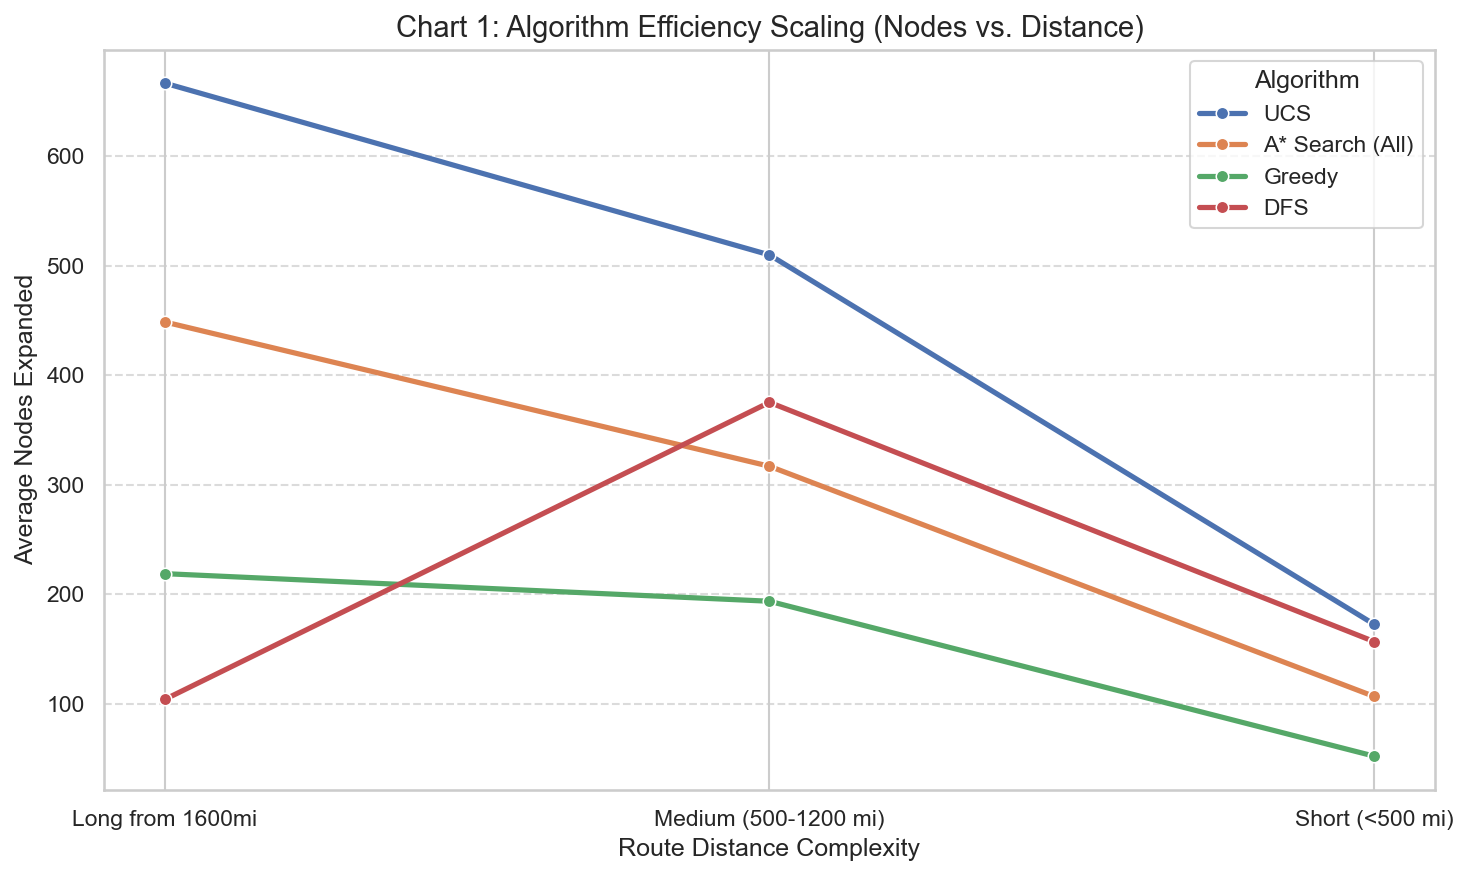

/var/folders/lc/f8cs0vmx0h93gdkcyd9sqq440000gq/T/ipykernel_15376/2919289904.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


In [32]:
plot_efficiency_scaling(df)
plot_optimality_gap_average(df)
plot_astar_ucs_savings(df)